In [3]:
# Import Libraries
from os import path
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set(style="whitegrid")
import random
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import average_precision_score
from sklearn.utils import shuffle
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
LABELS = ["Normal", "Fraud"]
import time

# Classifier Libraries 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import collections

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [4]:
DATA_DIR='/Users/adimehta/Desktop'

In [5]:
df = pd.read_csv(path.join(DATA_DIR, 'creditcard.csv'))

In [6]:
frauds = df.loc[df['Class'] == 1] # find all rows that are fraudulent
non_frauds = df.loc[df['Class'] == 0] # final all rows that aren't fraudulent
print('Frauds ', len(frauds), ' transactions or ', round(df['Class'].value_counts()[0]/len(df)*100, 2), '% of the dataset')
print('No Fraud ', len(non_frauds), ' transactions or ', round(df['Class'].value_counts()[1]/len(df)*100, 2), '% of the dataset')

Frauds  492  transactions or  99.83 % of the dataset
No Fraud  284315  transactions or  0.17 % of the dataset


In [7]:
avg_fraud_amount=frauds['Amount'].mean()
num_of_transactions=284315
num_of_fraud_transactions=492

In [8]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [9]:
df.isnull().sum().max()

0

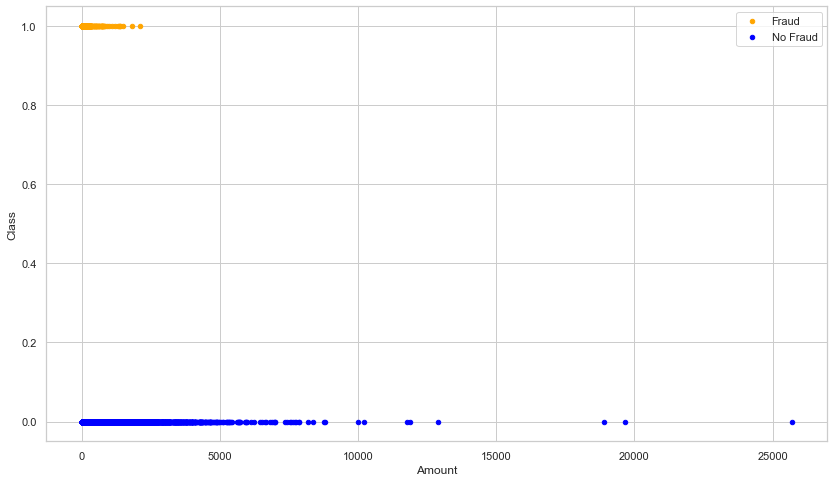

In [10]:
ax = frauds.plot.scatter(x='Amount', y='Class', color='Orange', label='Fraud')
non_frauds.plot.scatter(x='Amount', y='Class', color='Blue', label='No Fraud', ax=ax)
plt.show()

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

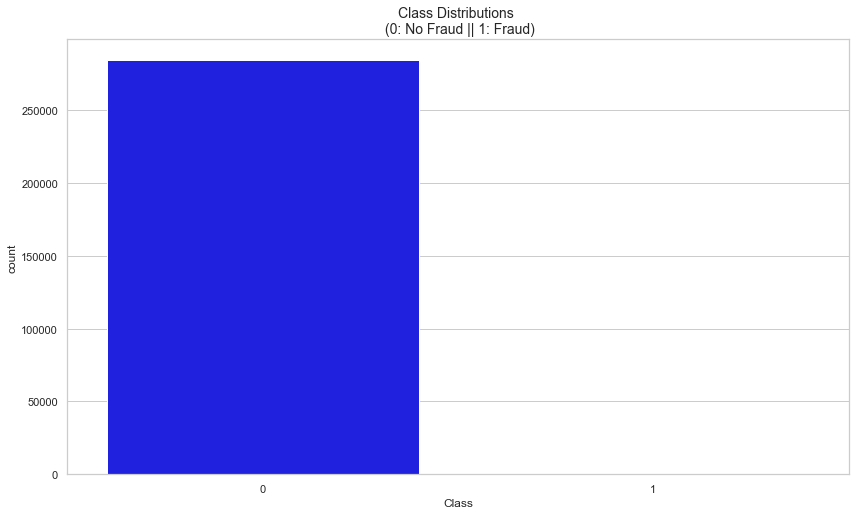

In [11]:
colors = ['Blue', 'Orange']

sns.countplot('Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

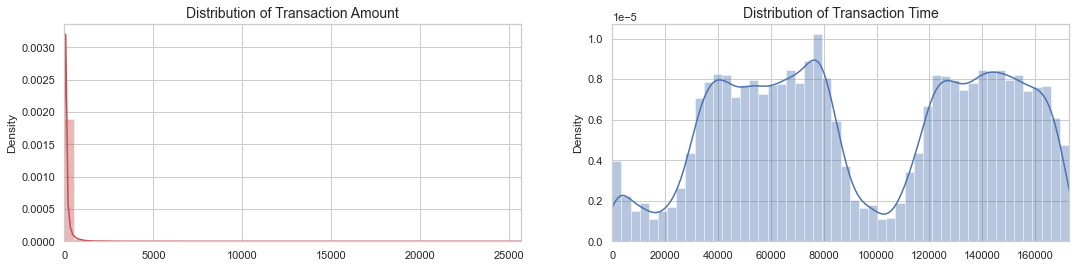

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

In [13]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True) # removing non-scaled time and
# amount from the dataframe

In [14]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True) # remove from end
df.insert(0, 'scaled_amount', scaled_amount) # place scaled amount at column 1
df.insert(1, 'scaled_time', scaled_time) # place scaled time at column 2

# Amount and Time are now scaled!

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [15]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df)*100, 2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df)*100, 2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in skf.split(X, y):
  print("Train:", train_index, "Test:", test_index)
  original_X_train, original_X_test = X.iloc[train_index], X.iloc[test_index]
  original_y_train, original_y_test = y.iloc[train_index], y.iloc[test_index]

# Turn into an array
original_X_train = original_X_train.values
original_X_test = original_X_test.values
original_y_train = original_y_train.values
original_y_test = original_y_test.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_y_train, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_y_test, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_y_train))
print(test_counts_label/ len(original_y_test))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


In [16]:
df = df.sample(frac=1)

# amount of fraud classes
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
217347,-0.197583,0.659829,1.873286,0.453629,-0.623282,3.725302,0.583346,0.603233,0.019312,0.094908,...,-0.229701,0.131625,0.514334,0.101544,0.775375,0.136334,0.039232,-0.031555,-0.051877,0
44223,1.647453,-0.503307,-19.139733,9.286847,-20.134992,7.818673,-15.652208,-1.668348,-21.340478,0.641900,...,0.427203,-2.182692,0.520543,-0.760556,0.662767,-0.948454,0.121796,-3.381843,-1.256524,1
42265,-0.146720,-0.513046,1.281329,-0.561295,0.641705,0.167984,-0.976727,-0.060507,-0.647384,0.034286,...,-0.553986,-0.441164,-0.535241,0.039547,0.099092,0.363869,0.441751,0.027563,0.014315,0
214775,-0.297771,0.647611,-0.395582,-0.751792,-1.984666,-0.203459,1.903967,-1.430289,-0.076548,-0.992260,...,-1.027716,1.377515,2.151787,0.189225,0.772943,-0.872443,-0.200612,0.356856,0.032113,1
238366,-0.279466,0.763026,0.754316,2.379822,-5.137274,3.818392,0.043203,-1.285451,-1.766684,0.756711,...,0.369663,0.397058,0.141165,0.171985,0.394274,-0.444642,-0.263189,0.304703,-0.044362,1


Distribution of the Classes in the subsample dataset
0    0.5
1    0.5
Name: Class, dtype: float64


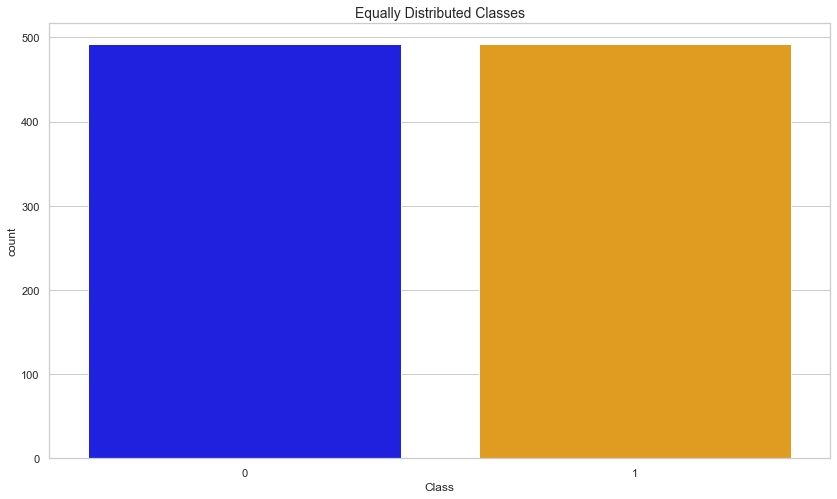

In [17]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df)) # percentage for each class

sns.countplot('Class', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

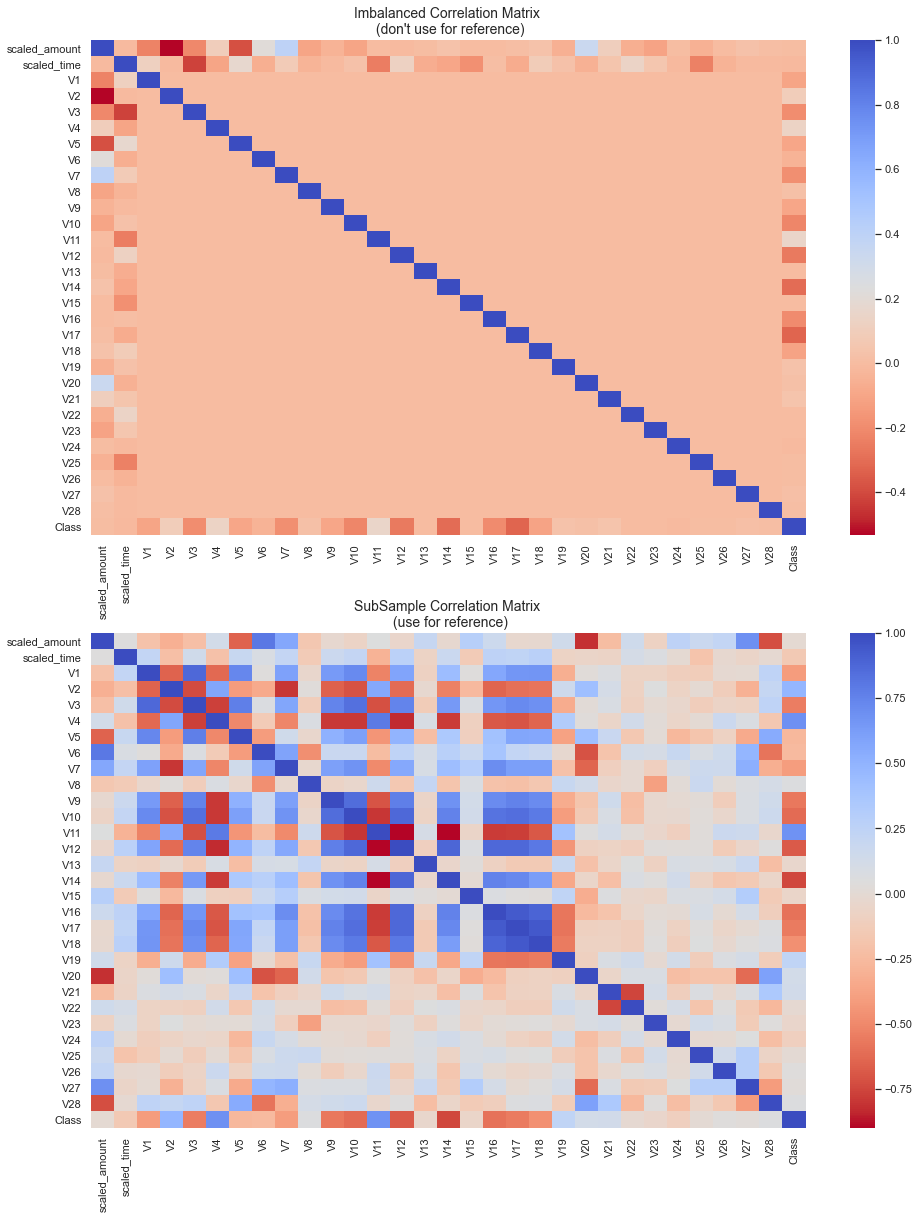

In [18]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 20))

# Entire DataFrame (to show how the correlation looks like in an imbalanced dataset)
corr = df.corr() # calculate correlation between features
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

# Subsampled DataFrame
sub_sample_corr = new_df.corr() # calculate correlation between features
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title("SubSample Correlation Matrix \n (use for reference)", fontsize=14)
plt.show()

In [19]:
sol = (sub_sample_corr.where(np.triu(np.ones(sub_sample_corr.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))

print(sol[0:9])
print(sol[-9:-1])

V17  V18    0.941157
V16  V17    0.933885
     V18    0.895149
V12  V14    0.881686
V10  V12    0.878987
V12  V16    0.877975
     V17    0.876725
V1   V3     0.875707
V9   V10    0.853607
dtype: float64
V11            V16   -0.787937
V4             V10   -0.789600
               V9    -0.793605
V2             V7    -0.799170
V10            V11   -0.799949
scaled_amount  V20   -0.810986
V4             V12   -0.831056
V11            V14   -0.894564
dtype: float64


In [20]:
print(sub_sample_corr['Class'].sort_values(ascending=False))

Class            1.000000
V4               0.692813
V11              0.686642
V2               0.481298
V19              0.240367
V21              0.137494
V20              0.125151
V8               0.062060
V28              0.058914
V26              0.039299
V27              0.021473
V25              0.005381
scaled_amount   -0.004013
V22             -0.012428
V13             -0.031763
V23             -0.039771
V15             -0.050522
V24             -0.099565
scaled_time     -0.152110
V6              -0.247185
V5              -0.267043
V7              -0.406063
V1              -0.414589
V18             -0.466061
V3              -0.544152
V17             -0.556524
V9              -0.570480
V16             -0.592349
V10             -0.623677
V12             -0.682976
V14             -0.747787
Name: Class, dtype: float64


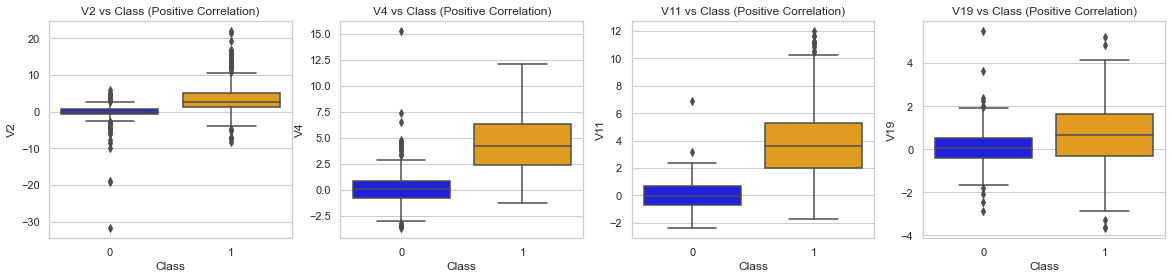

In [21]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Creating the boxplot
sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V2 vs Class (Positive Correlation)')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class (Positive Correlation)')

sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V11 vs Class (Positive Correlation)')

sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class (Positive Correlation)')

plt.show()

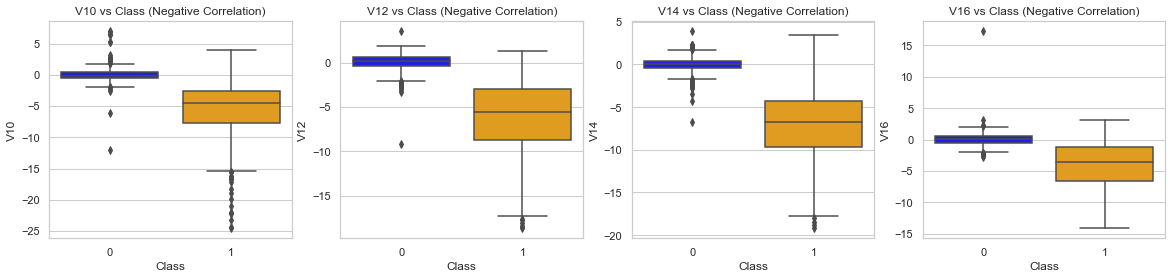

In [22]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Creating the boxplot (negative correlation)
sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V10 vs Class (Negative Correlation)')

sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V12 vs Class (Negative Correlation)')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V14 vs Class (Negative Correlation)')

sns.boxplot(x="Class", y="V16", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V16 vs Class (Negative Correlation)')

plt.show()

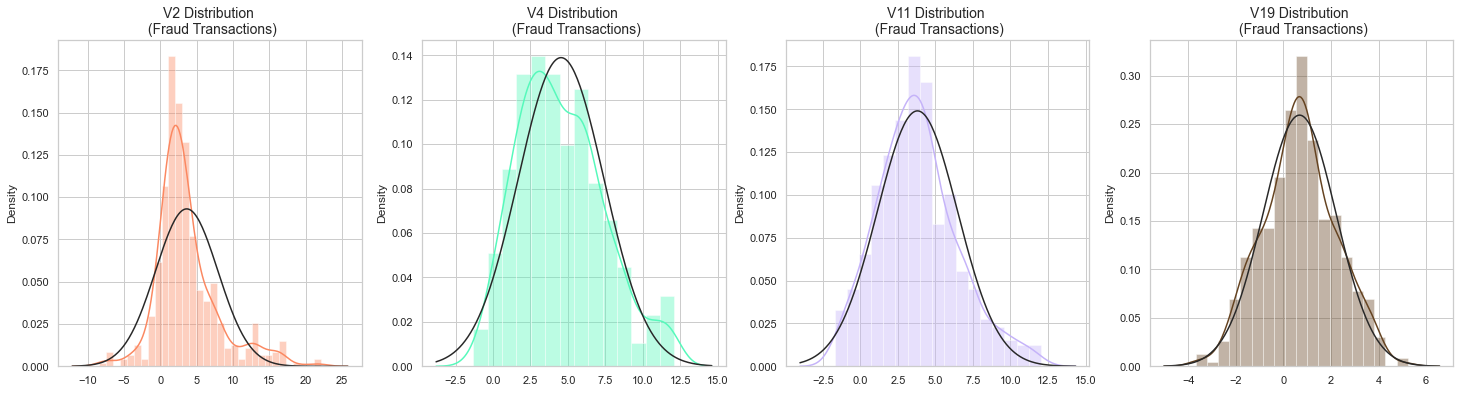

In [23]:
from scipy.stats import norm

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25, 6))

V2_fraud_dist = new_df['V2'].loc[new_df['Class'] == 1].values
sns.distplot(V2_fraud_dist, ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V2 Distribution \n (Fraud Transactions)', fontsize=14)

v4_fraud_dist = new_df['V4'].loc[new_df['Class'] == 1].values
sns.distplot(v4_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V4 Distribution \n (Fraud Transactions)', fontsize=14)


v11_fraud_dist = new_df['V11'].loc[new_df['Class'] == 1].values
sns.distplot(v11_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V11 Distribution \n (Fraud Transactions)', fontsize=14)

v19_fraud_dist = new_df['V19'].loc[new_df['Class'] == 1].values
sns.distplot(v19_fraud_dist,ax=ax4, fit=norm, color='#654321')
ax4.set_title('V19 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

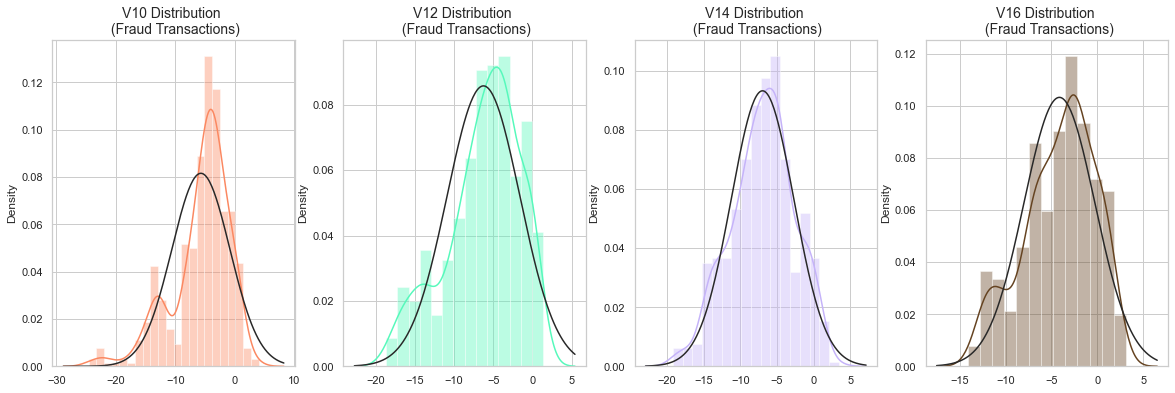

In [24]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 6))

V10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(V10_fraud_dist, ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v16_fraud_dist = new_df['V16'].loc[new_df['Class'] == 1].values
sns.distplot(v16_fraud_dist,ax=ax4, fit=norm, color='#654321')
ax4.set_title('V16 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [25]:
multiplier_for_threshold = 1.5

# -----> V14
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * multiplier_for_threshold
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

# check in V14 to find extreme outliers; the ones who pass the threshold
outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('V14 outliers:{}'.format(outliers))
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)

# -----> V12
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v12_iqr = q75 - q25
print('iqr: {}'.format(v12_iqr))

v12_cut_off = v12_iqr * multiplier_for_threshold
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))

new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# -----> V10
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v10_iqr = q75 - q25
print('iqr: {}'.format(v10_iqr))

v10_cut_off = v10_iqr * multiplier_for_threshold
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))

new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)

Quartile 25: -9.692722964972386 | Quartile 75: -4.282820849486865
iqr: 5.409902115485521
Cut Off: 8.114853173228282
V14 Lower: -17.807576138200666
V14 Upper: 3.8320323237414167
V14 outliers:[-19.2143254902614, -18.8220867423816, -18.0499976898594, -18.4937733551053]
Feature V14 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 979
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Quartile 25: -8.67303320439115 | Quartile 75: -2.893030568676315
iqr: 5.780002635714835
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.0475965708216, -18.6837146333443, -18.5536970096458, -18.4311310279993]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 975
-----------------------------------------------------------------------------------------------------------------------------------------------

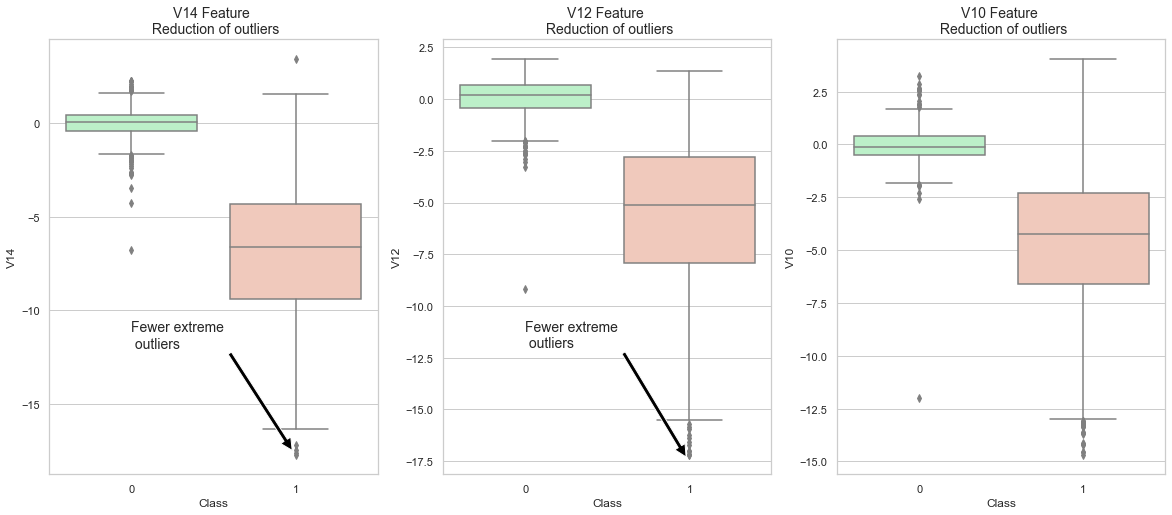

In [26]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,8))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

plt.show()

In [27]:
# let's update our inputs and outputs
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# t-SNE
t0 = time.time() # for calculating the time it takes to do t-SNE
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print('t-SNE took {:.2} s'.format(t1 - t0))

# PCA
t0 = time.time() # for calculating the time it takes to do t-SNE
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print('PCA took {:.2} s'.format(t1 - t0))

# Truncated SVD (basically PCA but for sparse data)
t0 = time.time() # for calculating the time it takes to do t-SNE
X_reduced_svd = TruncatedSVD(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print('Truncated SVD took {:.2} s'.format(t1 - t0))

t-SNE took 3.4 s
PCA took 0.023 s
Truncated SVD took 0.0024 s


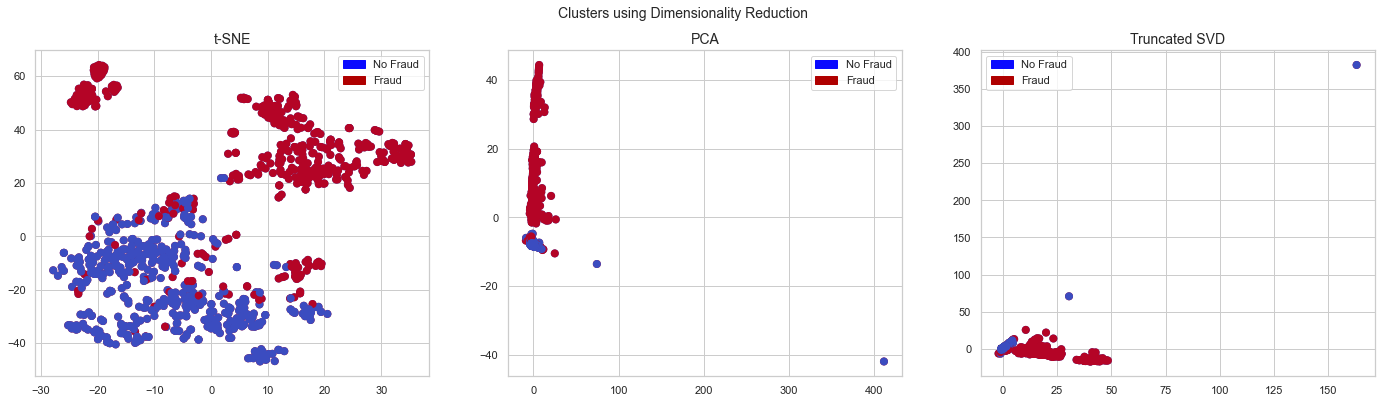

In [28]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

##### We see that the the data is split in a way where a model can be applied to seperate these two points

In [29]:
# let's update our inputs and outputs
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# Let's split our data in training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Turn values into an array for feeding the classifications algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

##### We are going to test different classifiers on our already undersampled data to select which one we will continue forward in applying more complex under and oversampling

In [30]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "RandomForestClassifier": RandomForestClassifier()
}

In [31]:
from sklearn.model_selection import cross_val_score
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression has a training score of 94.0 % accuracy score
Classifiers:  KNeighborsClassifier has a training score of 93.0 % accuracy score
Classifiers:  SVC has a training score of 93.0 % accuracy score
Classifiers:  RandomForestClassifier has a training score of 93.0 % accuracy score


In [32]:
from sklearn.model_selection import GridSearchCV
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
log_reg = grid_log_reg.best_estimator_
print(log_reg)

k_near_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_k_near = GridSearchCV(KNeighborsClassifier(), k_near_params)
grid_k_near.fit(X_train, y_train)
knears_neighbors = grid_k_near.best_estimator_
print(knears_neighbors)

svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)
svc = grid_svc.best_estimator_
print(svc)

rfc_params = {'n_estimators': [10, 20, 30, 40, 50], 'max_depth': [2, 3, 4, 7, 9]}
grid_rfc = GridSearchCV(RandomForestClassifier(), rfc_params)
grid_rfc.fit(X_train,y_train)
rfc=grid_rfc.best_estimator_
print(rfc)

LogisticRegression(C=1)
KNeighborsClassifier(n_neighbors=2)
SVC(C=0.5, kernel='linear')
RandomForestClassifier(max_depth=9, n_estimators=40)


#### These are the hyperparamters that work the best with each model

In [33]:
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(rfc, X_train, y_train, cv=5)
print('RandomForest Classifier Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  93.89%
Knears Neighbors Cross Validation Score 93.63%
Support Vector Classifier Cross Validation Score 93.89%
RandomForest Classifier Classifier Cross Validation Score 93.49%


In [86]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import PrecisionRecallDisplay
def completeCostBenefit(estimator,name):
    X = df.drop('Class', axis=1)
    y = df['Class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = X_train.values
    X_test = X_test.values
    y_train = y_train.values
    y_test = y_test.values
    clf=estimator
    t0 = time.time()
    clf.fit(X_train,y_train)
    t1 = time.time()
    
    y_pred=clf.predict(X_test)
    t2=time.time()
    cm=confusion_matrix(y_test,y_pred,labels=clf.classes_)
    tn=cm[0][0]
    fp=cm[1][0]
    fn=cm[0][1]
    tp=cm[1][1]
    
    detection_scale=num_of_transactions/(tn+fp+fn+tp)
    
    cost_wom=(fp+tp)*avg_fraud_amount*detection_scale*15.2185
    
    cost_of_executive_support=(fn+tp)*1.5*detection_scale*15.2185
    cost_lost_to_fraudulent_cases=(fp)*avg_fraud_amount*detection_scale*15.2185
    savings=cost_wom-cost_of_executive_support-cost_lost_to_fraudulent_cases
    
    ras=roc_auc_score(y_test,y_pred)
    acc=accuracy_score(y_test, y_pred)
    
    
    print(name)
    print("Model took {:.2} s".format(t1 - t0))
    print("Prediction took {:.2} s".format(t2 - t1))
    print("Precision Score: " + str(tp/(tp+fp)))
    print("Recall Score: " + str(tp/(tp+fn)))
    print("Accuracy Score: " +str(acc))
    print("ROC_AUC Score: " +str(ras))
    print("Cost incurred per month before the model was deployed: "+str(round(cost_wom,2)))
    print("Cost of executive support after model is deployed: "+str(round(cost_of_executive_support,2)))
    print("Cost incurred per month due to fraudulent cases after the model is deployed: "+str(round(cost_lost_to_fraudulent_cases,2)))
    print("Savings: "+str(round(savings,2)))
    print(cm)
        
    
    

In [87]:
completeCostBenefit(log_reg,"LogisticRegression")
print("-"*25)

LogisticRegression
Model took 1.5 s
Prediction took 0.0087 s
Precision Score: 0.56
Recall Score: 0.9032258064516129
Accuracy Score: 0.9991222218320986
ROC_AUC Score: 0.7799472406879815
Cost incurred per month before the model was deployed: 928320.27
Cost of executive support after model is deployed: 7064.3
Cost incurred per month due to fraudulent cases after the model is deployed: 408460.92
Savings: 512795.05
[[56856     6]
 [   44    56]]
-------------------------


In [88]:
completeCostBenefit(rfc,"RandomForestClassifier")
print("-"*25)

RandomForestClassifier
Model took 4e+01 s
Prediction took 0.18 s
Precision Score: 0.68
Recall Score: 0.9714285714285714
Accuracy Score: 0.999403110845827
ROC_AUC Score: 0.8399824135626606
Cost incurred per month before the model was deployed: 928320.27
Cost of executive support after model is deployed: 7975.83
Cost incurred per month due to fraudulent cases after the model is deployed: 297062.48
Savings: 623281.95
[[56860     2]
 [   32    68]]
-------------------------


In [89]:
completeCostBenefit(knears_neighbors,"KNearestNeighbors")
print("-"*25)

KNearestNeighbors
Model took 0.03 s
Prediction took 3.2e+02 s
Precision Score: 0.71
Recall Score: 0.9726027397260274
Accuracy Score: 0.9994557775359011
ROC_AUC Score: 0.8549824135626605
Cost incurred per month before the model was deployed: 928320.27
Cost of executive support after model is deployed: 8317.65
Cost incurred per month due to fraudulent cases after the model is deployed: 269212.88
Savings: 650789.74
[[56860     2]
 [   29    71]]
-------------------------


In [90]:
completeCostBenefit(svc,"SupportVectorClassifier")
print("-"*25)

SupportVectorClassifier
Model took 2.5e+03 s
Prediction took 0.85 s
Precision Score: 0.73
Recall Score: 0.8488372093023255
Accuracy Score: 0.9992977774656788
ROC_AUC Score: 0.8648856881572932
Cost incurred per month before the model was deployed: 928320.27
Cost of executive support after model is deployed: 9798.87
Cost incurred per month due to fraudulent cases after the model is deployed: 250646.47
Savings: 667874.92
[[56849    13]
 [   27    73]]
-------------------------


In [39]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values
def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

## Random Undersampling

In [79]:
X_ru = df.drop('Class', axis=1)
y_ru = df['Class']
X_ru_train, X_ru_test, y_ru_train, y_ru_test = train_test_split(X_ru, y_ru, test_size=0.2, random_state=42)
X_ru_train['Class']=y_ru_train
fraud_ru_df = X_ru_train.loc[X_ru_train['Class'] == 1]
non_fraud_ru_df = X_ru_train.loc[X_ru_train['Class'] == 0].sample(n=408)
ndf = pd.concat([fraud_df, non_fraud_df])
ru_df = ndf.sample(frac=1, random_state=42)
X_ru_train=ru_df.drop('Class', axis=1)
y_ru_train=ru_df['Class']

from sklearn.model_selection import GridSearchCV
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_ru_train, y_ru_train)
log_reg_ru = grid_log_reg.best_estimator_
print(log_reg_ru)

k_near_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_k_near = GridSearchCV(KNeighborsClassifier(), k_near_params)
grid_k_near.fit(X_ru_train, y_ru_train)
knears_neighbors_ru = grid_k_near.best_estimator_
print(knears_neighbors_ru)

svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_ru_train, y_ru_train)
svc_ru = grid_svc.best_estimator_
print(svc_ru)

rfc_params = {'n_estimators': [10, 20, 30, 40, 50], 'max_depth': [2, 3, 4, 7, 9]}
grid_rfc = GridSearchCV(RandomForestClassifier(), rfc_params)
grid_rfc.fit(X_ru_train, y_ru_train)
rfc_ru=grid_rfc.best_estimator_
print(rfc_ru)

LogisticRegression(C=1000)
KNeighborsClassifier(n_neighbors=2)
SVC(C=0.9, kernel='linear')
RandomForestClassifier(max_depth=7, n_estimators=20)


In [80]:
ndf.describe()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
count,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,...,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000
mean,1.448109,0.040146,-2.419697,1.722595,-3.564433,2.314432,-1.653303,-0.659675,-2.692376,0.261439,...,0.107372,0.315879,0.028815,0.009311,-0.047044,0.037695,0.032707,0.139620,0.036185,0.500000
std,11.924702,0.568925,5.676579,3.952122,6.378023,3.216929,5.612139,2.987386,7.087125,4.984790,...,2.118098,2.894032,1.188782,1.248255,0.583693,0.697885,0.482214,1.442325,0.670514,0.500254
min,-0.307413,-0.993597,-35.548539,-31.850484,-48.325589,-3.729432,-113.743307,-8.608727,-43.557242,-41.044261,...,-54.497720,-22.797604,-8.887017,-19.254328,-2.028024,-4.781606,-1.152671,-7.263482,-15.430084,0.000000
25%,-0.289772,-0.459988,-2.910316,-0.218435,-5.120349,-0.017820,-1.728805,-1.645612,-3.103817,-0.188989,...,-0.198922,-0.169006,-0.532981,-0.226403,-0.397250,-0.300566,-0.272150,-0.058972,-0.054872,0.000000
50%,-0.063648,-0.048603,-0.754354,0.903634,-1.343779,1.354709,-0.429213,-0.654913,-0.648629,0.163564,...,0.009327,0.143289,0.042653,-0.030940,0.003637,0.066687,-0.010091,0.055666,0.032366,0.500000
75%,1.088800,0.594200,1.099976,2.833075,0.339050,4.289110,0.491801,0.040824,0.177735,0.869452,...,0.450695,0.641307,0.614759,0.197549,0.375449,0.398682,0.319868,0.468181,0.220927,1.000000
max,358.683155,1.028443,2.335354,22.057729,3.180335,15.304184,17.370895,73.301626,120.589494,20.007208,...,11.059004,27.202839,8.361985,15.093942,4.584549,4.747061,3.415636,31.612198,5.202304,1.000000


In [81]:
def completeUndersampledCostBenefit(estimator,name):
    X_ru = df.drop('Class', axis=1)
    y_ru = df['Class']
    X_ru_train, X_ru_test, y_ru_train, y_ru_test = train_test_split(X_ru, y_ru, test_size=0.2, random_state=42)
    X_ru_train['Class']=y_ru_train
    fraud_ru_df = X_ru_train.loc[X_ru_train['Class'] == 1]
    non_fraud_ru_df = X_ru_train.loc[X_ru_train['Class'] == 0].sample(n=408)
    ndf = pd.concat([fraud_df, non_fraud_df])
    ru_df = ndf.sample(frac=1, random_state=42)
    X_ru_train=ru_df.drop('Class', axis=1)
    y_ru_train=ru_df['Class']


    X_ru_train = X_ru_train.values
    X_ru_test = X_ru_test.values
    y_ru_train = y_ru_train.values
    y_ru_test = y_ru_test.values
    clf=estimator
    t0=time.time()
    clf.fit(X_ru_train,y_ru_train)
    t1=time.time()
    y_pred=clf.predict(X_ru_test)
    t2=time.time()
    cm=confusion_matrix(y_ru_test,y_pred,labels=clf.classes_)
    tn=cm[0][0]
    fp=cm[1][0]
    fn=cm[0][1]
    tp=cm[1][1]
    
    detection_scale=num_of_transactions/(tn+fp+fn+tp)
    
    cost_wom=(fp+tp)*avg_fraud_amount*detection_scale*15.2185
    
    cost_of_executive_support=(fn+tp)*1.5*detection_scale*15.2185
    cost_lost_to_fraudulent_cases=(fp)*avg_fraud_amount*detection_scale*15.2185
    savings=cost_wom-cost_of_executive_support-cost_lost_to_fraudulent_cases
    
    ras=roc_auc_score(y_ru_test,y_pred)
    acc=accuracy_score(y_ru_test, y_pred)
    
    
    print(name)
    print("Model took {:.2} s".format(t1 - t0))
    print("Prediction took {:.2} s".format(t2 - t1))
    print("Precision Score: " + str(tp/(tp+fp)))
    print("Recall Score: " + str(tp/(tp+fn)))
    print("Accuracy Score: " +str(acc))
    print("ROC_AUC Score: " +str(ras))
    print("Cost incurred per month before the model was deployed: "+str(round(cost_wom,2)))
    print("Cost of executive support after model is deployed: "+str(round(cost_of_executive_support,2)))
    print("Cost incurred per month due to fraudulent cases after the model is deployed: "+str(round(cost_lost_to_fraudulent_cases,2)))
    print("Savings: "+str(round(savings,2)))
    print(cm)

In [82]:
completeUndersampledCostBenefit(log_reg_ru,"LogisticRegression")
print("-"*25)

LogisticRegression
Model took 0.028 s
Prediction took 0.0026 s
Precision Score: 0.92
Recall Score: 0.041970802919708027
Accuracy Score: 0.9629928724412766
ROC_AUC Score: 0.9415342407935
Cost incurred per month before the model was deployed: 928320.27
Cost of executive support after model is deployed: 249757.31
Cost incurred per month due to fraudulent cases after the model is deployed: 74265.62
Savings: 604297.34
[[54762  2100]
 [    8    92]]
-------------------------


In [83]:
completeUndersampledCostBenefit(rfc_ru,"RandomForest")
print("-"*25)

RandomForest
Model took 0.044 s
Prediction took 0.056 s
Precision Score: 0.96
Recall Score: 0.0663441603317208
Accuracy Score: 0.9762122116498718
ROC_AUC Score: 0.9681203615771518
Cost incurred per month before the model was deployed: 928320.27
Cost of executive support after model is deployed: 164871.73
Cost incurred per month due to fraudulent cases after the model is deployed: 37132.81
Savings: 726315.73
[[55511  1351]
 [    4    96]]
-------------------------


In [84]:
completeUndersampledCostBenefit(svc_ru,"SVC")
print("-"*25)

SVC
Model took 0.04 s
Prediction took 0.2 s
Precision Score: 0.92
Recall Score: 0.04930332261521972
Accuracy Score: 0.9687159860959939
ROC_AUC Score: 0.9444008300798424
Cost incurred per month before the model was deployed: 928320.27
Cost of executive support after model is deployed: 212612.74
Cost incurred per month due to fraudulent cases after the model is deployed: 74265.62
Savings: 641441.9
[[55088  1774]
 [    8    92]]
-------------------------


In [85]:
completeUndersampledCostBenefit(knears_neighbors_ru,"KNearestNeighbor")
print("-"*25)

KNearestNeighbor
Model took 0.00039 s
Prediction took 2.3 s
Precision Score: 0.89
Recall Score: 0.06458635703918723
Accuracy Score: 0.9771777676345634
ROC_AUC Score: 0.9336655411346769
Cost incurred per month before the model was deployed: 928320.27
Cost of executive support after model is deployed: 157009.84
Cost incurred per month due to fraudulent cases after the model is deployed: 102115.23
Savings: 669195.2
[[55573  1289]
 [   11    89]]
-------------------------


### Oversampling with SMOTE

In [49]:
X = df.drop('Class', axis=1)
y = df['Class']
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X, y, test_size=0.2, random_state=42)
sm = SMOTE(random_state=42)
X_smote_train, y_smote_train=sm.fit_resample(X_smote_train, y_smote_train)
X_smote_train['Class']=y_smote_train
fraud_smote_df = X_smote_train.loc[X_smote_train['Class'] == 1].sample(n=8000)
non_fraud_smote_df = X_smote_train.loc[X_smote_train['Class'] == 0].sample(n=8000)
ndf = pd.concat([fraud_smote_df, non_fraud_smote_df])
smote_df = ndf.sample(frac=1, random_state=42)
X_smote_train=smote_df.drop('Class', axis=1)
y_smote_train=smote_df['Class']

X_smote_train = X_smote_train.values
X_smote_test = X_smote_test.values
y_smote_train = y_smote_train.values
y_smote_test = y_smote_test.values

In [50]:
from sklearn.model_selection import GridSearchCV
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_smote_train, y_smote_train)
log_reg_smote = grid_log_reg.best_estimator_
print(log_reg_smote)

k_near_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_k_near = GridSearchCV(KNeighborsClassifier(), k_near_params)
grid_k_near.fit(X_smote_train, y_smote_train)
knears_neighbors_smote = grid_k_near.best_estimator_
print(knears_neighbors_smote)

svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_smote_train, y_smote_train)
svc_smote = grid_svc.best_estimator_
print(svc_smote)

rfc_params = {'n_estimators': [10, 20, 30, 40, 50], 'max_depth': [2, 3, 4, 7, 9]}
grid_rfc = GridSearchCV(RandomForestClassifier(), rfc_params)
grid_rfc.fit(X_smote_train, y_smote_train)
rfc_smote=grid_rfc.best_estimator_
print(rfc_smote)

LogisticRegression(C=100)
KNeighborsClassifier(n_neighbors=2)
SVC(C=1)
RandomForestClassifier(max_depth=9, n_estimators=30)


In [56]:
def completeSMOTECostBenefit(estimator,name):
    X = df.drop('Class', axis=1)
    y = df['Class']
    X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X, y, test_size=0.2, random_state=42)
    sm = SMOTE(random_state=42)
    X_smote_train, y_smote_train=sm.fit_resample(X_smote_train, y_smote_train)
    X_smote_train['Class']=y_smote_train
    fraud_smote_df = X_smote_train.loc[X_smote_train['Class'] == 1].sample(n=40000)
    non_fraud_smote_df = X_smote_train.loc[X_smote_train['Class'] == 0].sample(n=40000)
    ndf = pd.concat([fraud_smote_df, non_fraud_smote_df])
    smote_df = ndf.sample(frac=1, random_state=42)
    X_smote_train=smote_df.drop('Class', axis=1)
    y_smote_train=smote_df['Class']

    X_smote_train = X_smote_train.values
    X_smote_test = X_smote_test.values
    y_smote_train = y_smote_train.values
    y_smote_test = y_smote_test.values
    
    clf=estimator
    t0=time.time()
    clf.fit(X_smote_train,y_smote_train)
    t1=time.time()
    y_pred=clf.predict(X_smote_test)
    t2=time.time()
    cm=confusion_matrix(y_smote_test,y_pred,labels=clf.classes_)
    tn=cm[0][0]
    fp=cm[1][0]
    fn=cm[0][1]
    tp=cm[1][1]
    
    detection_scale=num_of_transactions/(tn+fp+fn+tp)
    
    cost_wom=(fp+tp)*avg_fraud_amount*detection_scale*15.2185
    
    cost_of_executive_support=(fn+tp)*1.5*detection_scale*15.2185
    cost_lost_to_fraudulent_cases=(fp)*avg_fraud_amount*detection_scale*15.2185
    savings=cost_wom-cost_of_executive_support-cost_lost_to_fraudulent_cases
    
    ras=roc_auc_score(y_smote_test,y_pred)
    acc=accuracy_score(y_smote_test, y_pred)
    
    
    print(name)
    print("Model took {:.2} s".format(t1 - t0))
    print("Prediction took {:.2} s".format(t2 - t1))
    print("Precision Score: " + str(tp/(tp+fp)))
    print("Recall Score: " + str(tp/(tp+fn)))
    print("Accuracy Score: " +str(acc))
    print("ROC_AUC Score: " +str(ras))
    print("Cost incurred per month before the model was deployed: "+str(round(cost_wom,2)))
    print("Cost of executive support after model is deployed: "+str(round(cost_of_executive_support,2)))
    print("Cost incurred per month due to fraudulent cases after the model is deployed: "+str(round(cost_lost_to_fraudulent_cases,2)))
    print("Savings: "+str(round(savings,2)))
    print(cm)

In [57]:
completeSMOTECostBenefit(log_reg_smote,"LogReg")

LogReg
Model took 0.41 s
Prediction took 0.0037 s
Precision Score: 0.89
Recall Score: 0.06597479614529281
Accuracy Score: 0.9776868789719462
ROC_AUC Score: 0.9339205444761001
Cost incurred per month before the model was deployed: 928320.27
Cost of executive support after model is deployed: 153705.57
Cost incurred per month due to fraudulent cases after the model is deployed: 102115.23
Savings: 672499.47
[[55602  1260]
 [   11    89]]


In [58]:
completeSMOTECostBenefit(rfc_smote,"RandomForestClassifier")

RandomForestClassifier
Model took 6.8 s
Prediction took 0.11 s
Precision Score: 0.8
Recall Score: 0.3686635944700461
Accuracy Score: 0.9972437765527896
ROC_AUC Score: 0.8987953290422426
Cost incurred per month before the model was deployed: 928320.27
Cost of executive support after model is deployed: 24725.06
Cost incurred per month due to fraudulent cases after the model is deployed: 185664.05
Savings: 717931.15
[[56725   137]
 [   20    80]]


In [59]:
completeSMOTECostBenefit(knears_neighbors_smote,"K-Nearest Neighbors")

K-Nearest Neighbors
Model took 0.012 s
Prediction took 8.2e+01 s
Precision Score: 0.82
Recall Score: 0.31906614785992216
Accuracy Score: 0.9966117762719006
ROC_AUC Score: 0.9084611867327915
Cost incurred per month before the model was deployed: 928320.27
Cost of executive support after model is deployed: 29282.68
Cost incurred per month due to fraudulent cases after the model is deployed: 167097.65
Savings: 731939.94
[[56687   175]
 [   18    82]]


In [60]:
completeSMOTECostBenefit(svc_smote,"SVC Neighbors")

SVC Neighbors
Model took 5.7e+01 s
Prediction took 5.6e+01 s
Precision Score: 0.87
Recall Score: 0.09688195991091314
Accuracy Score: 0.9855342157929848
ROC_AUC Score: 0.9278686996588232
Cost incurred per month before the model was deployed: 928320.27
Cost of executive support after model is deployed: 102318.46
Cost incurred per month due to fraudulent cases after the model is deployed: 120681.63
Savings: 705320.17
[[56051   811]
 [   13    87]]


## Using a stacked algorithim for classification

In [202]:
from sklearn.metrics import plot_confusion_matrix, roc_auc_score, plot_roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import StackingClassifier, StackingRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [203]:
thisdict = [
  ("rfc", rfc_smote),
  ("svc", svc_smote),
  ("log_reg", log_reg_smote),
  ("knn", knears_neighbors_smote)
]

In [204]:
stack_model=StackingClassifier(estimators=thisdict,final_estimator=LogisticRegression())

In [205]:
completeSMOTECostBenefit(stack_model,"Stacked Model")

Stacked Model
Precision Score: 0.8958333333333334
Recall Score: 0.3346303501945525
Accuracy Score: 0.9968224430321969
ROC_AUC Score: 0.9464131320414073
Cost incurred per month before the model was deployed: 891187.45
Cost of executive support after model is deployed: 29282.68
Cost incurred per month due to fraudulent cases after the model is deployed: 92832.03
Savings: 769072.75
[[56695   171]
 [   10    86]]


## Early Experimentation with Statsmodels

In [181]:
import statsmodels.api as sm
X_ru = df.drop('Class', axis=1)
y_ru = df['Class']
X_ru_train, X_ru_test, y_ru_train, y_ru_test = train_test_split(X_ru, y_ru, test_size=0.2, random_state=42)
X_ru_train['Class']=y_ru_train
fraud_ru_df = X_ru_train.loc[X_ru_train['Class'] == 1]
non_fraud_ru_df = X_ru_train.loc[X_ru_train['Class'] == 0].sample(n=408)
ndf = pd.concat([fraud_df, non_fraud_df])
ru_df = ndf.sample(frac=1, random_state=42)
X_ru_train=ru_df.drop('Class', axis=1)
y_ru_train=ru_df[['Class']]

log_reg_sm = sm.Logit(y_ru_train, X_ru_train).fit(method='bfgs')
print(log_reg_sm.summary())

         Current function value: 0.218998
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                           Logit Regression Results                           
Dep. Variable:                  Class   No. Observations:                  984
Model:                          Logit   Df Residuals:                      954
Method:                           MLE   Df Model:                           29
Date:                Wed, 24 Aug 2022   Pseudo R-squ.:                  0.6841
Time:                        16:41:02   Log-Likelihood:                -215.49
converged:                      False   LL-Null:                       -682.06
Covariance Type:            nonrobust   LLR p-value:                1.132e-177
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
scaled_amount    -1.8339      0.175    -10.490      0.000      -2.176 

/Users/adimehta/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [182]:
y_pred=log_reg_sm.predict(X_ru_test)
prediction = list(map(round, y_pred))
cm = confusion_matrix(y_ru_test, prediction) 
print ("Confusion Matrix : \n", cm) 
  

Confusion Matrix : 
 [[52159  4707]
 [    7    89]]
